## 프로젝트 소개
플라즈마 이상 신호를 진단하기 위해 광 신호를 활용하는 센서를 개발 중입니다.

![플라즈마 이미지](image/project/plasma.jpg)

PMT 소자를 활용하여 플라즈마에서 방출된 photon을 electron으로 변환하여 세기를 측정하는 방식입니다.

데이터 형식은 1차원 배열로, 센서에서는 두 가지 형태의 데이터를 생성합니다:
1. **Streaming Data**: 초당 10,000,000 포인트를 생성합니다.
2. **Trend Data**: 초당 200 포인트를 생성하며, Streaming Data에서 최소값, 최대값, 평균을 50,000 포인트마다 샘플링하여 생성합니다.

현재 데이터의 양이 많아서 사람이 수동으로 데이터를 확인하고 있습니다.

Trend Data는 비교적 쉽게 확인할 수 있지만, Streaming Data로는 데이터 양이 많아서 사람이 수동으로 확인하기 어렵습니다.

이번 교육을 통해 머신러닝/딥러닝을 활용하여 데이터를 자동으로 분석하여 이상 신호 진단 결과를 도출하는 모델을 개발하고자 합니다.


### 센서 신호 정의

신호의 세기는 0 ~ 5 값이며, 값은 소수점 6 자리까지 나옵니다.

데이터 반출 문제로 센서 데이터를 생성해야 합니다.

trend data (200 points/s)도 만들기 어려워 (10 points/s) 데이터를 수동으로 만들었습니다.

총 7개 이며 신호는 아래와 같습니다

![signal_1](image/base_signal/signal_1.png)
![signal_2](image/base_signal/signal_2.png)
![signal_3](image/base_signal/signal_3.png)
![signal_4](image/base_signal/signal_4.png)
![signal_5](image/base_signal/signal_5.png)
![signal_6](image/base_signal/signal_6.png)
![signal_7](image/base_signal/signal_7.png)

### 정상 신호의 정의

정상 신호는 다음과 같이 정의됩니다:

- **Stable한 신호**: 단계가 변경될 때를 제외하고 안정적으로 유지되는 신호입니다.

![normal](image/project/normal.png)

### 이상 신호의 정의
이상 신호는 다음과 같이 정의됩니다:

1. **Outlier 발생 지점**: 안정적인 신호에서 벗어나 이상 현상이 발생한 지점입니다.

![outlier](image/project/outlier.png)

2. **Variation이 커지는 영역**: 안정적인 신호에서 변동이 크게 나타나는 지점입니다.

![noise](image/project/noise.png)

### 특이 사항

![신호 step](image/project/signal_step.png)

위 그림과 같이 step(구간) 별로 step 시작 부분에 신호 변곡점이 생기는데 해당 부분은 이상 신호로 진단하지 말아야 합니다.

전처리로 해당 특이 사항을 제거했다는 가정하에, stable한 구간에서 이상 신호를 만들려고 합니다.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### 함수 설명

- **add_outlier_signal**: 특정 구간에 이상치(outlier)를 생성하는 함수 (n개의 이상치를 추가)
- **add_noise_signal**: 정규 분포 노이즈를 생성하여 신호에 추가하는 함수 (특정 범위 내에서)

### 정상/비정상 신호 생성

기본 신호(Base Signal)를 기반으로 다음 두 가지 함수를 사용하여 정상 및 비정상 신호를 생성합니다:

1. **정상 신호 (Normal Signal)**
   - 기본 신호에 `add_noise_signal` 함수를 적용하여 생성합니다.
   - 전체 신호에 0.01%의 랜덤 노이즈를 추가합니다. (SNR=1000, Signal 1000 : Noise 1)

2. **이상치 신호 (Outlier Signal)**
   - 기본 신호에 0.01%의 랜덤 노이즈를 추가한 후, `add_outlier_signal` 함수를 적용하여 생성합니다.
   - 특정 구간에 이상치를 추가합니다.

3. **노이즈 신호 (Noise Signal)**
   - 기본 신호에 0.01%의 랜덤 노이즈를 추가한 후, `add_noise_signal` 함수를 적용하여 생성합니다.
   - 특정 구간에 정규 분포 노이즈를 추가합니다.

In [2]:
SNR = 1000

In [3]:
def generate_data(signal_func, num_samples, *args):
    data_list = []
    for _ in range(num_samples):
        val = signal_func(*args)
        data_list.append(val)
    res = np.vstack(data_list)
    return np.round(res, 6)

def make_signal_with_noise(signal):
    signal_with_noise = np.copy(signal)
    signal_with_noise += np.random.normal(scale=1/SNR, size=len(signal))
    return signal_with_noise

def add_outlier_signal(signal, outlier_ratio, range_, n_outlier=1):
    start, end = range_
    modified_signal = make_signal_with_noise(signal)
    outlier_index_list = np.random.choice(range(start, end+1), size=n_outlier, replace=False)
    for outlier_index in outlier_index_list:
        modified_signal[outlier_index] *= outlier_ratio
    return modified_signal

def add_noise_signal(signal, noise_ratio, range_):
    start, end = range_
    noisy_signal = make_signal_with_noise(signal)
    noisy_signal[start:end+1] += np.random.normal(scale=np.mean(signal)*noise_ratio, size=end-start+1)
    return noisy_signal

In [4]:
def get_original_signal():
    return {i: np.loadtxt(f'./data/raw/trend_data{i}.csv', delimiter=',') for i in range(1, 8)}

In [5]:
signal_dict = get_original_signal()

위의 기본 신호 7개 중, 다양한 신호 패턴을 다룰 수 있게 4개의 기본 신호를 선정했습니다.

![signal_1](image/base_signal/signal_1.png)
![signal_2](image/base_signal/signal_2.png)
![signal_3](image/base_signal/signal_3.png)
![signal_5](image/base_signal/signal_5.png)

또한 기본 신호마다 outlier, noise 추가할 구간을 나눠주었습니다.

In [6]:
base_signal_idx = [1, 2, 3, 5]
base_signal_dict = {key: signal_dict[key] for key in base_signal_idx}
base_signal_section = {
    1: [(200, 400), (500, 700), (850, 940)],
    2: [(200, 800), (900, 950), (1030, 1080)],
    3: [(200, 500), (600, 750), (800, 900)],
    5: [(50, 200), (400, 1200), (1450, 1510)]
}

만든 함수를 이용해 신호를 생성

random으로 생성 신호를 추출하여 그래프를 그려 유효한지 확인

In [7]:
signal_idx = 1
section_idx = 0

n_normal_samples = 10000

outlier_ratio = 1.4
n_outlier = 1
n_outlier_samples = 1000

noise_ratio = 0.05
n_noise_samples = 1000

section = base_signal_section[signal_idx][section_idx]
signal = base_signal_dict[signal_idx]

normal_signal = generate_data(add_noise_signal, n_normal_samples, signal, 1/SNR, [0, len(signal)-1])
outlier_signal_array = generate_data(add_outlier_signal, n_outlier_samples, signal, outlier_ratio, section, n_outlier)
noise_signal_array = generate_data(add_noise_signal, n_noise_samples, signal, noise_ratio, section)

In [8]:
def check_signal_validity(signal, n_samples, n_cols=2):
    indices = np.random.choice(len(signal), n_samples, replace=False)
    for i, idx in enumerate(indices):
        plt.subplot(n_samples//n_cols+1, n_cols, i+1)
        plt.plot(signal[idx])
        plt.title(f'Sample {i+1}')
    plt.tight_layout()
    plt.show()

normal signal (10000, 972)


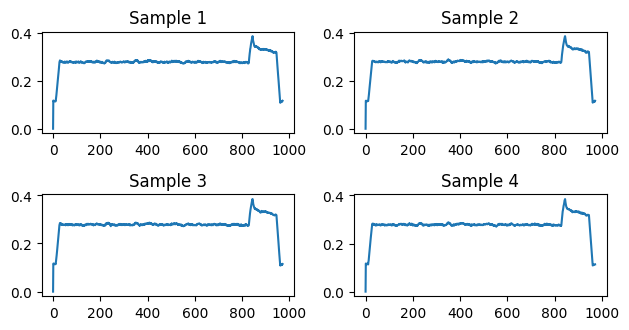

outlier signal (1000, 972)


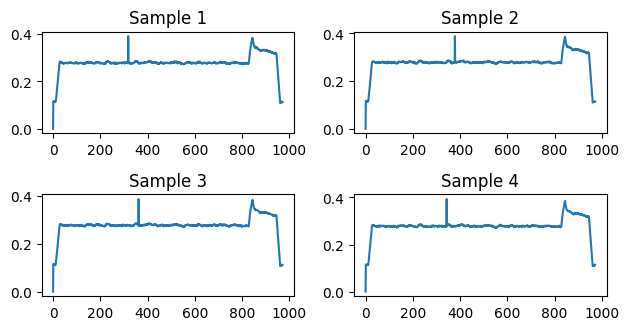

noise signal (1000, 972)


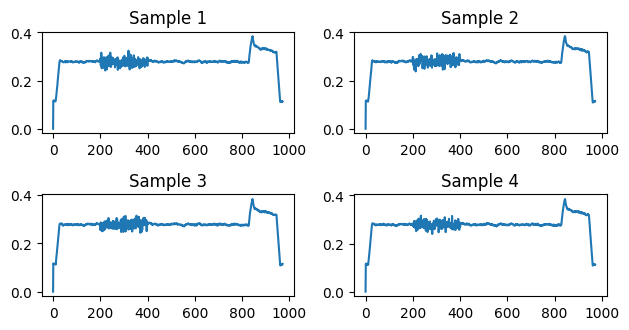

In [9]:
n_samples = 4
print('normal signal', normal_signal.shape)
check_signal_validity(normal_signal, n_samples)
print('outlier signal', outlier_signal_array.shape)
check_signal_validity(outlier_signal_array, n_samples)
print('noise signal', noise_signal_array.shape)
check_signal_validity(noise_signal_array, n_samples)

### 정상/비정상 신호 생성 기준

기본 신호 4개 기준, section은 3개로 전부 동일 (즉, 신호 1개당 3개 구간)

1. **정상 신호 (Normal Signal)**
   - 개수: 10,000 개

2. **이상치 신호 (Outlier Signal)**
   - 개수: 1,800 개 (구간 별 600 개)
   - 크기: 기존 신호의 1.4배
   - 개수: 1 point

3. **노이즈 신호 (Noise Signal)**
   - 개수: 1,800 개 (구간 별 600 개)
   - 크기: 기존 신호 + 신호 평균 * 0.05 scale을 갖는 정규분포

### Target columns 설명
1. **Target**
   - 0: 정상 신호
   - 1: 이상치 신호 (구간 1)
   - 2: 노이즈 신호 (구간 1)
   - 3: 이상치 신호 (구간 2)
   - 4: 노이즈 신호 (구간 2)
   - 5: 이상치 신호 (구간 3)
   - 6: 노이즈 신호 (구간 3)

2. **Section**
   - 구간 (순서대로 1, 2, 3)
   - signal 1: [(200, 400), (500, 700), (850, 940)]
   - signal 2: [(200, 800), (900, 950), (1030, 1080)]
   - signal 3: [(200, 500), (600, 750), (800, 900)]
   - signal 5: [(50, 200), (400, 1200), (1450, 1510)]

In [10]:
# data 만드는 기준 정보
n_normal_samples = 10000

outlier_ratio = 1.4
n_outlier = 1
n_outlier_samples = 600

noise_ratio = 0.05
n_noise_samples = 600

target_normal = 0

In [11]:
total_dict = {}
for signal_idx, signal in base_signal_dict.items():
    normal_signal = generate_data(add_noise_signal, n_normal_samples, signal, 1/SNR, [0, len(signal)-1])
    row_data = np.copy(normal_signal)
    
    for section in base_signal_section[signal_idx]:
        signal = signal_dict[signal_idx]

        outlier_signal_array = generate_data(add_outlier_signal, n_outlier_samples, signal, outlier_ratio, section, n_outlier)
        noise_signal_array = generate_data(add_noise_signal, n_noise_samples, signal, noise_ratio, section)
        
        row_data = np.vstack((row_data, outlier_signal_array, noise_signal_array))
    
    s = 0
    e = n_normal_samples

    df = pd.DataFrame(row_data)    
    df.loc[s:e, 'target'] = target_normal
    for i, v in enumerate(base_signal_section):
        s = e
        e = s+n_outlier_samples
        df.loc[s:e, 'target'] = i+1
        
        s = e
        e = s+n_noise_samples
        df.loc[s:e, 'target'] = i+4
        
    df['target'] = df['target'].astype(int)
    
    total_dict[signal_idx] = df

value_counts, bar plot, pie plot 이용, 개수 확인 결과 완료 (아래 코드 및 사진)

정상 신호: 10,000 개, 이상치 신호: 1,800 개 (구간 별 600 개), 노이즈 신호: 1,800 개 (구간 별 600 개)

In [12]:
import matplotlib.cm as cm

colors = cm.Set3.colors

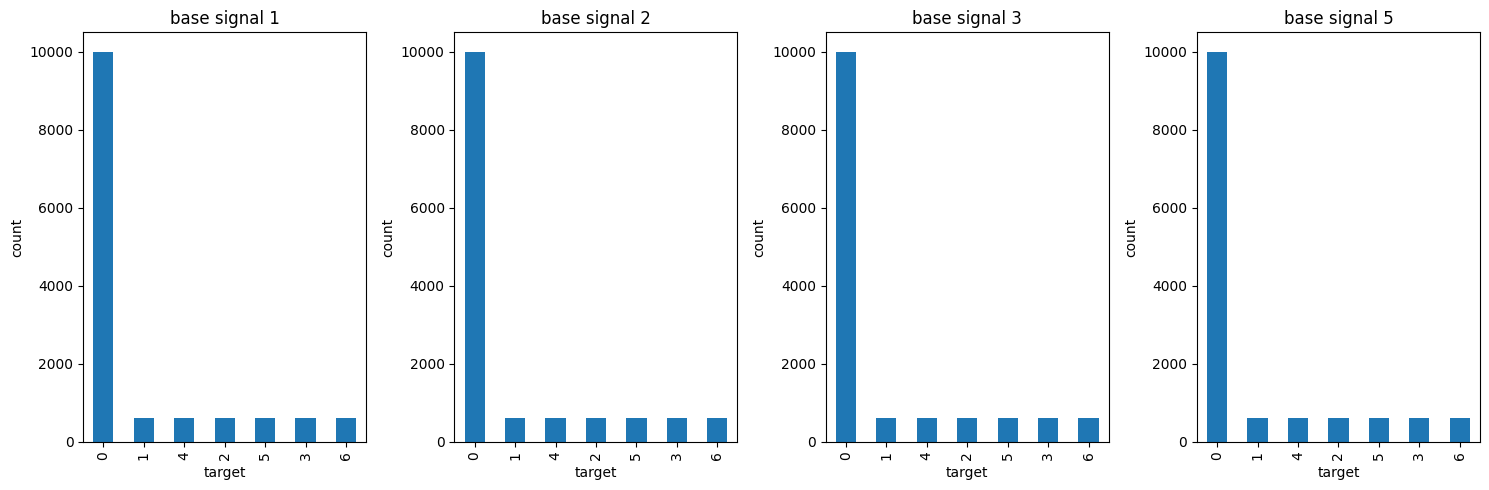

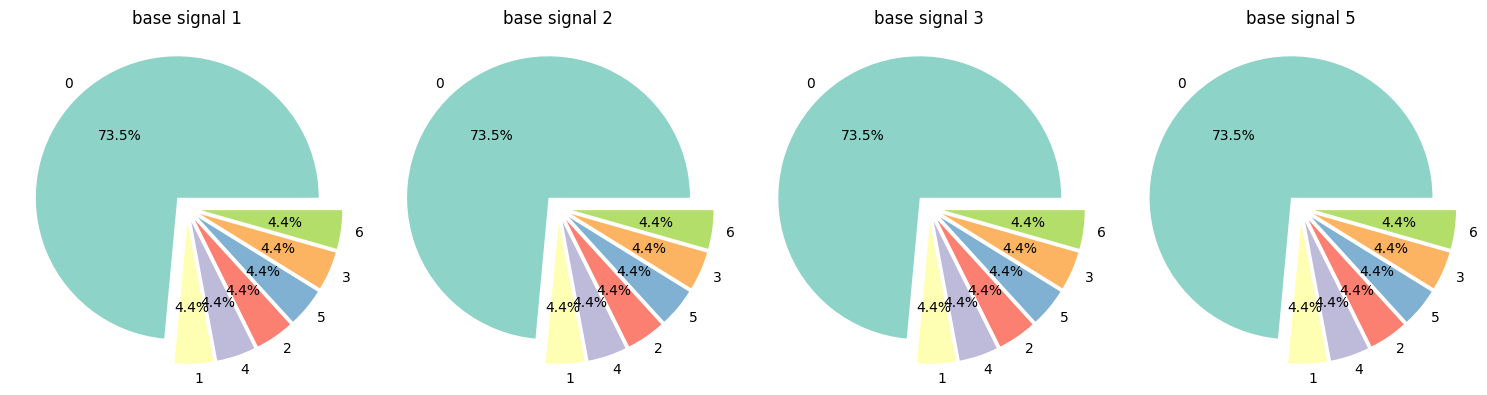

In [13]:
plt.figure(figsize=(15, 5))
for i, (key, value) in enumerate(total_dict.items(), start=1):
    plt.subplot(1, len(total_dict), i)
    
    x = total_dict[1]['target'].value_counts().index
    y = total_dict[1]['target'].value_counts().values
    total_dict[1]['target'].value_counts().plot(kind='bar', stacked=True, ax=plt.gca())
    
    plt.title(f'base signal {key}')
    plt.xlabel('target')
    plt.ylabel('count')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 5))
for i, (key, value) in enumerate(total_dict.items(), start=1):
    plt.subplot(1, len(total_dict), i)
    
    counts = total_dict[key]['target'].value_counts()
    explode = [0.1] * len(counts)
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%', explode=explode, colors=colors)
    plt.title(f'base signal {key}')
plt.tight_layout()
plt.show()

구간 별로 제대로 신호가 제대로 만들어졌는지 np.random.choice를 이용, 무작위로 뽑아 확인 결과 잘 만들어짐

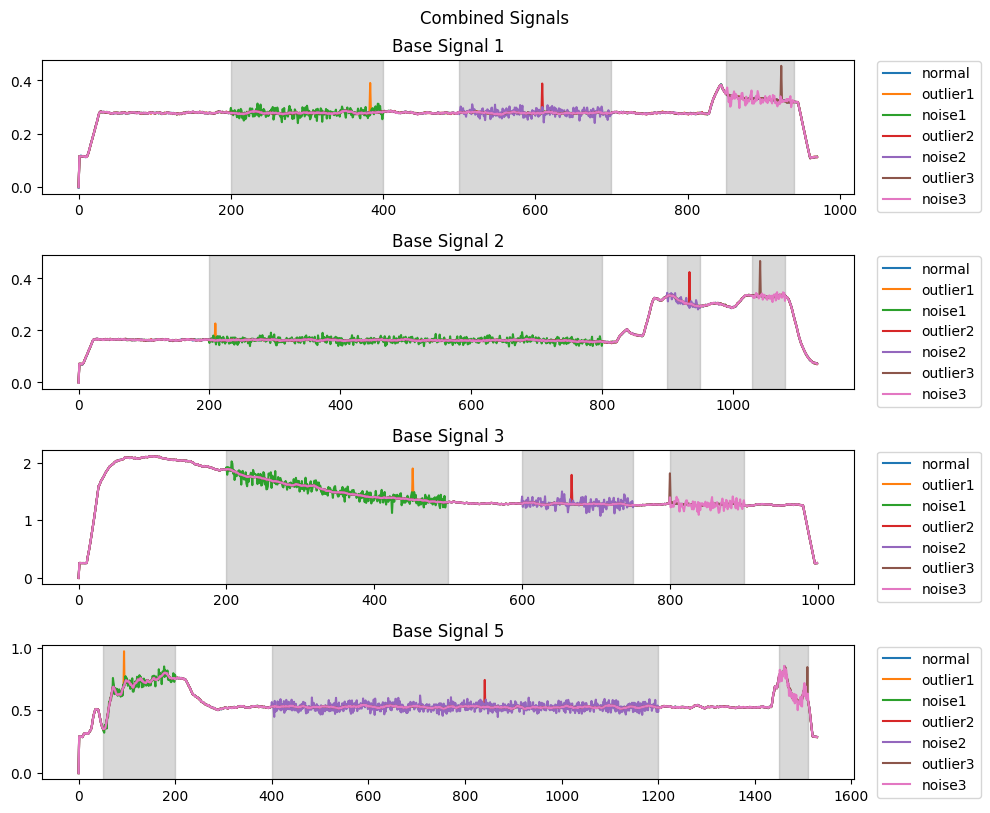

In [14]:
def generate_indices(start, end):
    return np.random.choice(range(start, end))

plt.figure(figsize=(10, 10))
plt.suptitle('Combined Signals')
for i, signal_idx in enumerate(base_signal_idx, start=1):
    signal_data = total_dict[signal_idx].iloc[:,:-2]
    normal = signal_data.iloc[generate_indices(0, 10000)]
    outlier1 = signal_data.iloc[generate_indices(10000, 10600)]
    noise1 = signal_data.iloc[generate_indices(10600, 11200)]
    outlier2 = signal_data.iloc[generate_indices(11200, 11800)]
    noise2 = signal_data.iloc[generate_indices(11800, 12400)]
    outlier3 = signal_data.iloc[generate_indices(12400, 13000)]
    noise3 = signal_data.iloc[generate_indices(13000, 13600)]

    plt.subplot(5, 1, i)
    plt.title(f'Base Signal {signal_idx}')
    plt.plot(normal, label='normal')
    plt.plot(outlier1, label='outlier1')
    plt.plot(noise1, label='noise1')
    plt.plot(outlier2, label='outlier2')
    plt.plot(noise2, label='noise2')
    plt.plot(outlier3, label='outlier3')
    plt.plot(noise3, label='noise3')
    for idx in base_signal_section[signal_idx]:
        plt.axvspan(xmin=idx[0], xmax=idx[1], color='gray', alpha=0.3)
    
    plt.legend(bbox_to_anchor=(1.02, 1.04), loc='upper left')
plt.tight_layout()
plt.show()

무작위 랜덤으로 아래 코드를 여러번 돌렸을 때도 잘 만들어졌음을 확인 완료

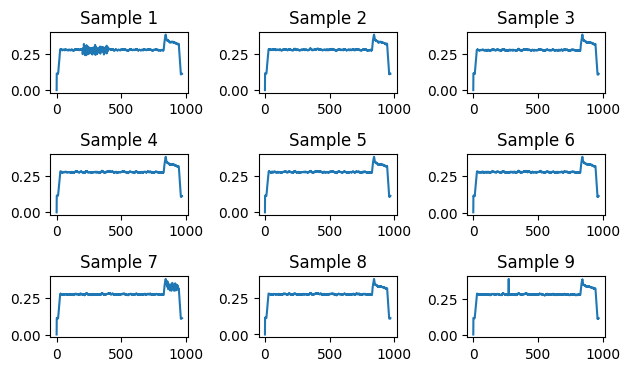

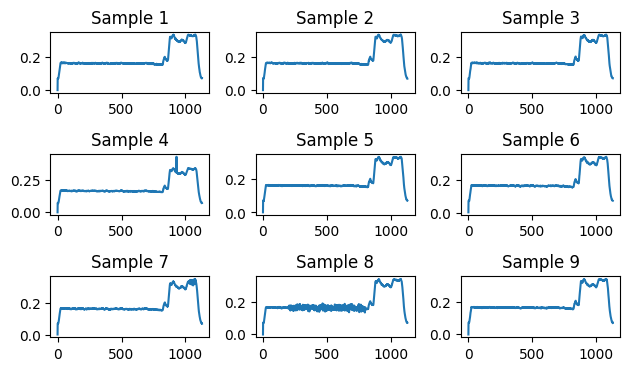

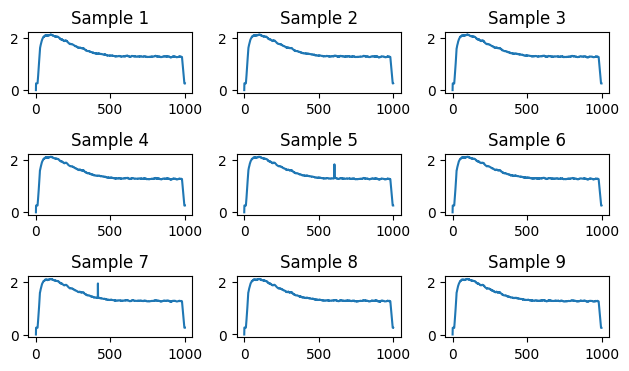

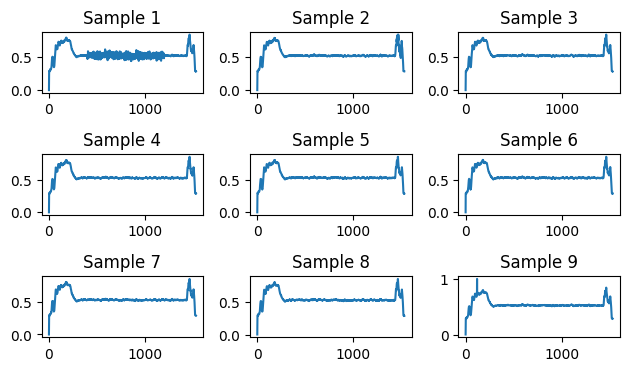

In [15]:
for signal_idx in base_signal_idx:
    arr = np.array(total_dict[signal_idx].iloc[:,:-2])
    check_signal_validity(arr, 9, 3)

만든 데이터를 csv 형태로 저장

- if not os.path.exists 코드는 Run All 할 떄마다 파일이 만들어지는데 100MB가 넘는 파일이라 오래 걸려 넣어 논 것

In [16]:
if not os.path.exists("./data/signal/data_1.csv"):
    for key, value in total_dict.items():
        filename = f"./data/signal/data_{key}.csv"
        value.to_csv(filename, index=False)

# 기본 신호 파형

![signal_1](image/base_signal/signal_1.png)
![signal_2](image/base_signal/signal_2.png)
![signal_3](image/base_signal/signal_3.png)
![signal_5](image/base_signal/signal_5.png)